## Access to market / Gambia

One of the most important aspects in development is access to/from resources. For example access to  hospitals, to schools, to markets...

The idea of this project is to focus on measuring this accessibility, either by assessing the transportation road conditions (find new, missing roads, or pavement quality) or calculate the distance from the harvested fields to the ports or markets.

For example, in Gambia [1/3 of the GPD](https://en.wikipedia.org/wiki/Economy_of_the_Gambia) is agriculture, and about [75% of the population depends on crops](https://rainforests.mongabay.com/deforestation/archive/Gambia.htm).

We could, for example, calculate first the location of planted areas, and then the travel times between these and the closest villages, or port (for exports). This will give us information of the operating cost and effort to produce the harvest, and could help us calculate the impact when a particular road is upgraded, or degraded.

### Data available:

- Landsat/Copernicus Level-1 at different times.
- Satellogic Hyperspectral where available.
- Historical Hyperion where available.


## This notebook

This notebook summarizes the idea of the project, links to relevant sources and kickstarts the initial steps getting the software and data to start working


### Troubleshoot
* This is meant to work with python 3.
* If you see `Import error` it will probably work by doing `conda install <package>`
* IF you get an error `Import error: /Users/brunosan/anaconda3/lib/libgdal.20.dylib. Reason: image not found` try `conda install  libgdal=2.0.0`

## Load a satellogic hyperspectral data from the region


Hyperspectral data can easily overpower your system resources (31 bands x 1500 width x 1500 height x 16bit/pixel is a lot or memory).

The strategy here is going to be to:
* Use the RGB color raster created by Satellogic, 
* Downsample the RGB 25% (25%^2 or ~6% of the filesize) to make it easier to work with, 
* Select a small windows of interest, and 
* Finally load all the hyperspectral data for that window.

Once you know the exact computation you might want to script it for the whole raster.

In [1]:
import os
import numpy as np

hypercube_folder="./data/satellogic/macro/2018-02-25_143937_telluric_catalog_set_257e80_gUflxSO/newsat3_macro_cube_257e8052c6d94b72ada0b788173791fa_0_4_3/rasters/"
files=os.listdir(hypercube_folder) 

rgb_file=[x for x in files if 'rgb' in x][0]
hfiles=np.sort([x for x in files if x[-6:]=='nm.tif'])

print("RGB file: %s. Number of Spectral bands: %i" % (rgb_file,len(hfiles)))

RGB file: rgb_enhanced.tif. Number of Spectral bands: 30


In [2]:
import rasterio
import numpy as np
from pprint import pprint

path = hypercube_folder+rgb_file
with rasterio.open(path) as src:
    array = src.read()

stats = []
for band in array:
    stats.append({
        'min': band.min(),
        'mean': band.mean(),
        'median': np.median(band),
        'max': band.max()})
print("File: ",path)
pprint(stats)


File:  ./data/satellogic/macro/2018-02-25_143937_telluric_catalog_set_257e80_gUflxSO/newsat3_macro_cube_257e8052c6d94b72ada0b788173791fa_0_4_3/rasters/rgb_enhanced.tif
[{'max': 255, 'mean': 57.63533623945361, 'median': 0.0, 'min': 0},
 {'max': 255, 'mean': 59.979174784728, 'median': 0.0, 'min': 0},
 {'max': 255, 'mean': 58.489598013690475, 'median': 0.0, 'min': 0}]


In [ ]:
dataset = rasterio.open(path)
print("Data types:",{i: dtype for i, dtype in zip(dataset.indexes, dataset.dtypes)})
print("Bounds:",dataset.bounds)
print("CRS:",dataset.crs)

In [ ]:
#Resample to make smaller
from rasterio.warp import Affine,reproject,Resampling

resampled_path = hypercube_folder+'resampled_rgb.tif'
resample_factor=0.25 #(1/4 on the side, typically 1/4^2 reduction is filesize)

with rasterio.drivers(CHECK_WITH_INVERT_PROJ=True):
    with rasterio.open(path) as src:
        profile = src.profile

        # Calculate the ideal dimensions and transformation in the new crs
        aff = dataset.affine
        dst_affine=Affine(aff[0] / resample_factor, aff[1], aff[2],
                aff[3], aff[4] / resample_factor, aff[5])
        dst_width=int(src.width*resample_factor)
        dst_height=int(src.height*resample_factor)

        # update the relevant parts of the profile
        profile.update({
            'crs': src.crs,
            'transform': dst_affine,
            'affine': dst_affine,
            'width': dst_width,
            'height': dst_height
        })

        # Reproject and write each band
        with rasterio.open(resampled_path, 'w', **profile) as dst:
            for i in range(1, src.count + 1):
                src_array = src.read(i)
                dst_array = np.empty((dst_height, dst_width), dtype='uint8')

                reproject(
                    # Source parameters
                    source=src_array,
                    src_crs=src.crs,
                    src_transform=src.affine,
                    # Destination paramaters
                    destination=dst_array,
                    dst_transform=dst_affine,
                    dst_crs=src.crs,
                    # Configuration
                    resampling=Resampling.nearest,
                    num_threads=4)

                dst.write(dst_array, i)

In [ ]:
#quick overall plot
%matplotlib inline

from matplotlib import pyplot
from rasterio.plot import show
from rasterio.plot import show_hist

with rasterio.open(resampled_path) as resampled:
 fig, (axrgb, axhist) = pyplot.subplots(1, 2, figsize=(14,7))
 show(resampled, ax=axrgb)
 show_hist(resampled, bins=50, histtype='stepfilled',
          lw=0.0, stacked=False, alpha=0.3, ax=axhist)
 pyplot.show()

In [5]:
#Plot the subregion to focus on, around the capital of Gambia, Banjul. 
import fiona
import rasterio
from rasterio.mask import mask

roi_path=hypercube_folder+"banjul.tif"
#to mask the region we need both images in the same CRS
with fiona.open("banjul-3857.geojson", "r") as shapefile:
    geoms = [feature["geometry"] for feature in shapefile]

#we use the full resolution
with rasterio.open(path) as src:
    out_image, out_transform = mask(src, geoms, crop=True)
    out_meta = src.meta.copy()

out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rasterio.open(roi_path, "w", **out_meta) as dest:
 dest.write(out_image)

In [ ]:
with rasterio.open(roi_path) as resampled:
 fig, (axrgb, axhist) = pyplot.subplots(1, 2, figsize=(14,7))
 show(resampled, ax=axrgb)
 show_hist(resampled, bins=50, histtype='stepfilled',
          lw=0.0, stacked=False, alpha=0.3, ax=axhist)
 pyplot.show()

In [6]:
#Read ALL bands, 
# mask them into the ROI and 
# save them into a single multiband cube

roi_path=hypercube_folder+"banjul.tif"

cube_dtype=np.uint8 #np.uint16 to have more spectral flux resolution.
cube=np.zeros((np.shape(out_image.data)[1], np.shape(out_image.data)[2],len(hfiles)),dtype=np.uint8)

#to mask the region we need both images in the same CRS
with fiona.open("banjul-3857.geojson", "r") as shapefile:
    geoms = [feature["geometry"] for feature in shapefile]
    
max_cast=45000
min_cast=0

print("Reading files...",end='')
for i in np.arange(len(hfiles[:])):
    file=hfiles[i]
    print(file,end=", "),
    with rasterio.open(hypercube_folder+file) as src:
        out_image, out_transform = mask(src, geoms, crop=True)
        if out_image.data.dtype == cube.dtype:
            cube[:,:,i]=out_image.data
        else:
            #cast to uint8, to save space
            cube[:,:,i]=((np.clip(out_image.data,min_cast,max_cast)-min_cast)/(max_cast-min_cast))*np.iinfo(cube.dtype).max
print("")

Reading files...HyperCube_452_nm.tif, HyperCube_462_nm.tif, HyperCube_475_nm.tif, HyperCube_488_nm.tif, HyperCube_502_nm.tif, HyperCube_516_nm.tif, HyperCube_530_nm.tif, HyperCube_550_nm.tif, HyperCube_570_nm.tif, HyperCube_582_nm.tif, HyperCube_595_nm.tif, HyperCube_608_nm.tif, HyperCube_616_nm.tif, HyperCube_670_nm.tif, HyperCube_680_nm.tif, HyperCube_690_nm.tif, HyperCube_700_nm.tif, HyperCube_710_nm.tif, HyperCube_720_nm.tif, HyperCube_730_nm.tif, HyperCube_740_nm.tif, HyperCube_750_nm.tif, HyperCube_760_nm.tif, HyperCube_770_nm.tif, HyperCube_780_nm.tif, HyperCube_790_nm.tif, HyperCube_800_nm.tif, HyperCube_810_nm.tif, HyperCube_820_nm.tif, HyperCube_827_nm.tif, 


<IPython.core.display.Javascript object>


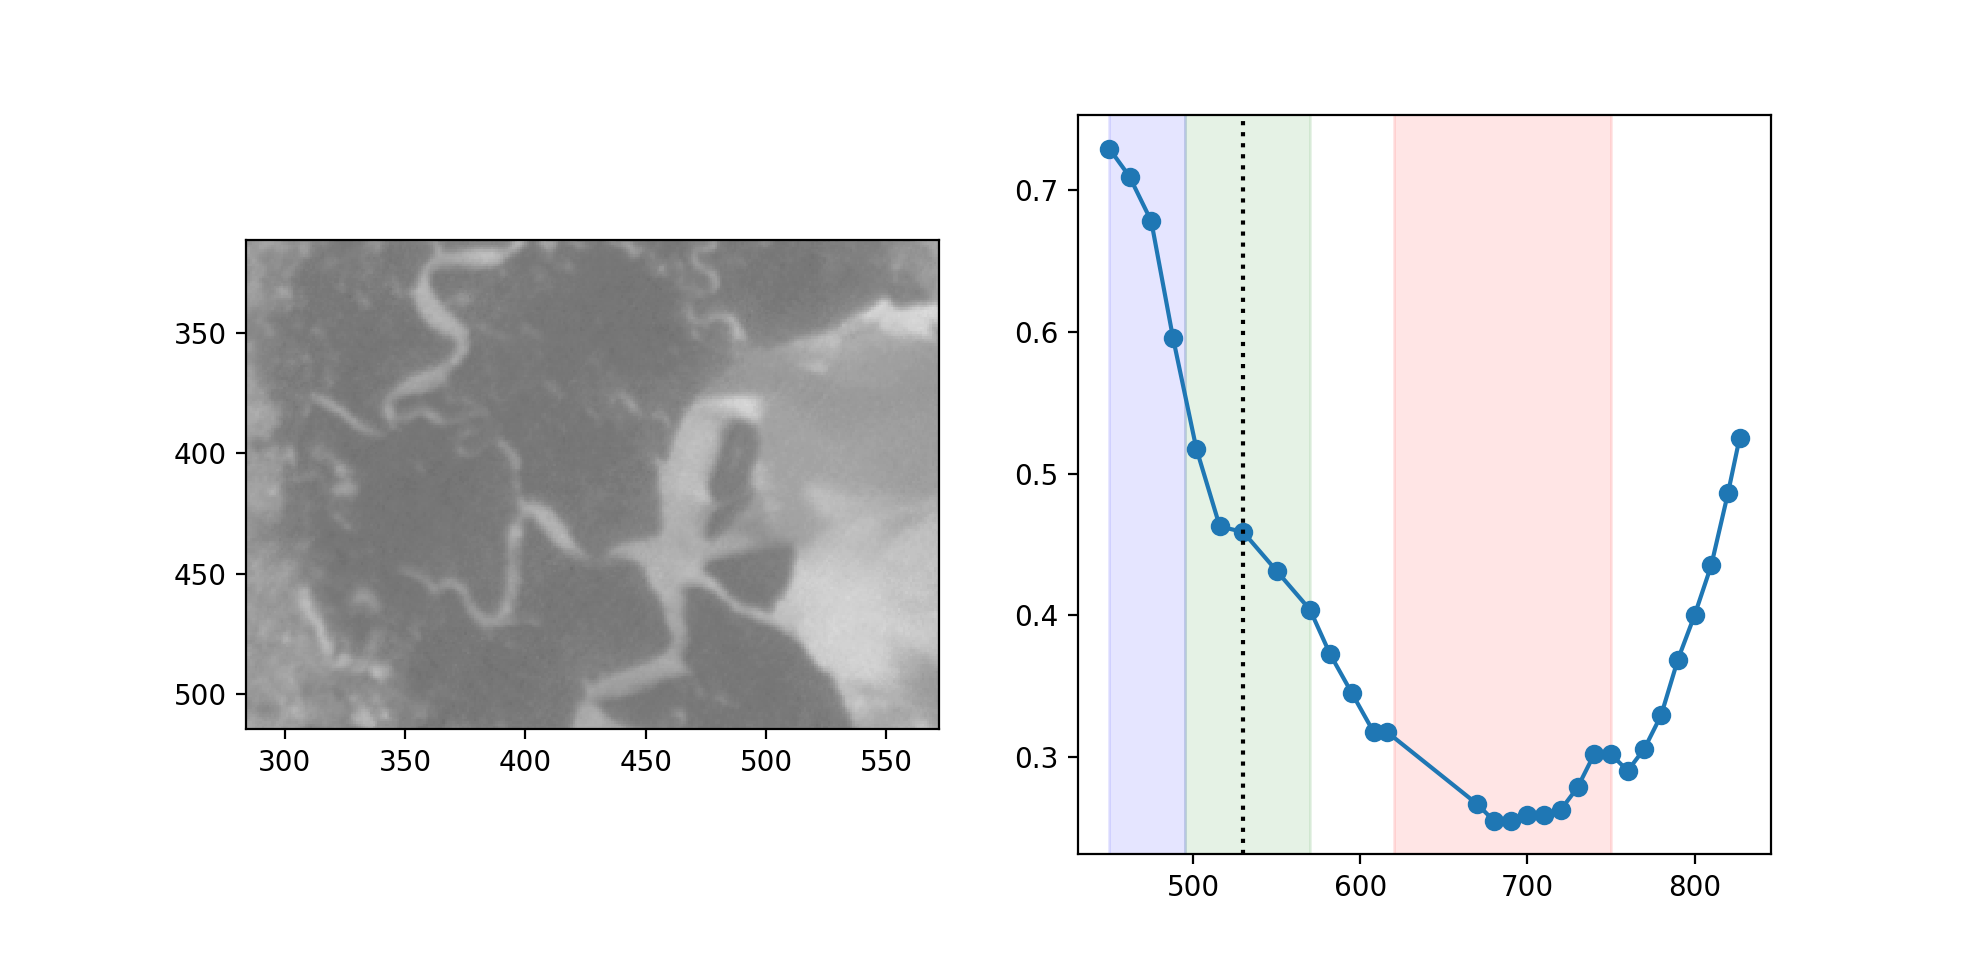

interactive(children=(IntSlider(value=15, description='Channel', max=29), Output()), _dom_classes=('widget-interact',))

<function __main__.spectrogram>

In [8]:
%matplotlib notebook
%matplotlib notebook
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

wavelengths = np.asarray([450, 462, 475, 488, 502, 516, 530, 550, 570, 582, 595, 608, 616, 670, 680, 690, 700, 710, 720, 730, 740, 750, 
                                   760 , 770, 780, 790, 800, 810, 820, 827])


i=int(len(hfiles)/2)    
x=int(cube.shape[0]/2)
y=int(cube.shape[1]/2)
fig=plt.figure(0)
im=plt.subplot(121)
s=plt.subplot(122)

im.cla()
im.imshow(cube[:,:,i])

red=[620,750]
green=[495,570]
blue=[450,495]
def spectra(i,x,y):
    s.cla()
    s.plot(wavelengths,cube[y,x,:]/255,'o-')
    s.axvline(x=wavelengths[i],linestyle=':',color='black')
    
    #add RGB reference
    for p in [
    patches.Rectangle(
        (red[0], 0), red[1]-red[0], 1,
        alpha=.1,Color='red'
    ),
    patches.Rectangle(
        (green[0], 0), green[1]-green[0], 1,
        alpha=.1,Color='green'
    ),
    patches.Rectangle(
        (blue[0], 0), blue[1]-blue[0], 1,
        alpha=.1,Color='blue'
    ),
]:
        s.add_patch(p)
    plt.show()

def onclick(event):
    x=int(event.xdata)
    y=int(event.ydata)
    i=i_slider.value
    spectra(i,x,y)
im.figure.canvas.mpl_connect('button_press_event', onclick)
    

def spectrogram(i):
    im.imshow(cube[:,:,i], cmap='gray')
    spectra(i,x,y)

spectrogram(i)
i_slider = widgets.IntSlider(min=0,
                             max=len(hfiles)-1,
                             step=1,
                             value=len(hfiles)/2,
                             description='Channel')
interact(spectrogram, i=i_slider)


In [ ]:
from skimage.feature import register_translation

for i in np.arange(len(hfiles[:])-1):
    shift, error, diffphase = register_translation(cube[920:1020,320:420,15], cube[920:1020,320:420,i],1)
    print(i,shift)
print("")


In [ ]:
fig.set_rasterized